# Natural Language Processing with RNNs - Toxic Comment Classification

Outline:

1. Download and explore the data
2. Prepare the data for training
3. Build a recurrent neural network
4. Train & evaluate the model
5. Make predictions & submit to Kaggle

## Download & Explore Data

Outline:
1. Download the data from Kaggle
2. Load data into Pandas dataframes
3. Explore the dataset

In [ ]:
import os

In [ ]:
os.environ['KAGGLE_CONFIG_DIR'] = '.'

In [ ]:
!kaggle competitions download -c jigsaw-toxic-comment-classification-challenge

 47% 25.0M/52.6M [00:00<00:00, 76.3MB/s]
100% 52.6M/52.6M [00:00<00:00, 108MB/s] 


In [ ]:
!unzip jigsaw-toxic-comment-classification-challenge -d data

Archive:  jigsaw-toxic-comment-classification-challenge.zip
  inflating: data/sample_submission.csv.zip  
  inflating: data/test.csv.zip       
  inflating: data/test_labels.csv.zip  
  inflating: data/train.csv.zip      


In [ ]:
import pandas as pd
import numpy as np

In [ ]:
raw_df = pd.read_csv('data/train.csv.zip')
test_df = pd.read_csv('data/test.csv.zip')
sub_df = pd.read_csv('data/sample_submission.csv.zip')

In [ ]:
raw_df.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


In [ ]:
raw_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159571 entries, 0 to 159570
Data columns (total 8 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   id             159571 non-null  object
 1   comment_text   159571 non-null  object
 2   toxic          159571 non-null  int64 
 3   severe_toxic   159571 non-null  int64 
 4   obscene        159571 non-null  int64 
 5   threat         159571 non-null  int64 
 6   insult         159571 non-null  int64 
 7   identity_hate  159571 non-null  int64 
dtypes: int64(6), object(2)
memory usage: 9.7+ MB


In [ ]:
target_cols = list(raw_df.columns[-6:])
target_cols

['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']

In [ ]:
for col in target_cols:
  print(raw_df[col].value_counts(normalize=True))
  print()

0    0.904156
1    0.095844
Name: toxic, dtype: float64

0    0.990004
1    0.009996
Name: severe_toxic, dtype: float64

0    0.947052
1    0.052948
Name: obscene, dtype: float64

0    0.997004
1    0.002996
Name: threat, dtype: float64

0    0.950636
1    0.049364
Name: insult, dtype: float64

0    0.991195
1    0.008805
Name: identity_hate, dtype: float64



In [ ]:
test_df

,id,comment_text
0,00001cee341fdb12,Yo bitch Ja Rule is more succesful then you'll...
1,0000247867823ef7,== From RfC == \n\n The title is fine as it is...
2,00013b17ad220c46,""" \n\n == Sources == \n\n * Zawe Ashton on Lap..."
3,00017563c3f7919a,":If you have a look back at the source, the in..."
4,00017695ad8997eb,I don't anonymously edit articles at all.
...,...,...
153159,fffcd0960ee309b5,". \n i totally agree, this stuff is nothing bu..."
153160,fffd7a9a6eb32c16,== Throw from out field to home plate. == \n\n...
153161,fffda9e8d6fafa9e,""" \n\n == Okinotorishima categories == \n\n I ..."
153162,fffe8f1340a79fc2,""" \n\n == """"One of the founding nations of the..."


In [ ]:
sub_df

,id,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,00001cee341fdb12,0.5,0.5,0.5,0.5,0.5,0.5
1,0000247867823ef7,0.5,0.5,0.5,0.5,0.5,0.5
2,00013b17ad220c46,0.5,0.5,0.5,0.5,0.5,0.5
3,00017563c3f7919a,0.5,0.5,0.5,0.5,0.5,0.5
4,00017695ad8997eb,0.5,0.5,0.5,0.5,0.5,0.5
...,...,...,...,...,...,...,...
153159,fffcd0960ee309b5,0.5,0.5,0.5,0.5,0.5,0.5
153160,fffd7a9a6eb32c16,0.5,0.5,0.5,0.5,0.5,0.5
153161,fffda9e8d6fafa9e,0.5,0.5,0.5,0.5,0.5,0.5
153162,fffe8f1340a79fc2,0.5,0.5,0.5,0.5,0.5,0.5


## Prepare the Dataset for Training

Outline:
- Create a vocabulary using TorchText
- Create training & validation sets
- Create PyTorch dataloaders

### Create a Vocabulary

In [ ]:
from torchtext.data.utils import get_tokenizer

In [ ]:
tokenizer = get_tokenizer('basic_english')

In [ ]:
sample_comment = raw_df.comment_text.values[0]

In [ ]:
sample_comment

"Explanation\nWhy the edits made under my username Hardcore Metallica Fan were reverted? They weren't vandalisms, just closure on some GAs after I voted at New York Dolls FAC. And please don't remove the template from the talk page since I'm retired now.89.205.38.27"

In [ ]:
sample_comment_token = tokenizer(sample_comment)
', '.join(sample_comment_token)

"explanation, why, the, edits, made, under, my, username, hardcore, metallica, fan, were, reverted, ?, they, weren, ', t, vandalisms, ,, just, closure, on, some, gas, after, i, voted, at, new, york, dolls, fac, ., and, please, don, ', t, remove, the, template, from, the, talk, page, since, i, ', m, retired, now, ., 89, ., 205, ., 38, ., 27"

In [ ]:
from torchtext.vocab import build_vocab_from_iterator

In [ ]:
comment_tokens = raw_df.comment_text.map(tokenizer)

In [ ]:
VOCAB_SIZE = 1500

In [ ]:
unk_token = '<unk>'
pad_token = '<pad>'

In [ ]:
vocab = build_vocab_from_iterator(comment_tokens,
                                  specials=[unk_token, pad_token],
                                  max_tokens=VOCAB_SIZE)

In [ ]:
vocab['this']

18

In [ ]:
vocab[unk_token]

0

In [ ]:
vocab.set_default_index(vocab[unk_token])

In [ ]:
vocab['hardcore']

0

In [ ]:
sample_indices = vocab.lookup_indices(sample_comment_token)
sample_indices[:10]

[667, 85, 3, 140, 142, 185, 39, 663, 0, 0]

In [ ]:
sample_comment_recovered = vocab.lookup_tokens(sample_indices)
sample_comment_recovered[:10]

['explanation',
 'why',
 'the',
 'edits',
 'made',
 'under',
 'my',
 'username',
 '<unk>',
 '<unk>']

### Create Training & Validation Sets

- Define a custom Pytorch Dataset
- Pass raw data into the dataset
- Split the PyTorch Dataset

In [ ]:
from torch.utils.data import Dataset

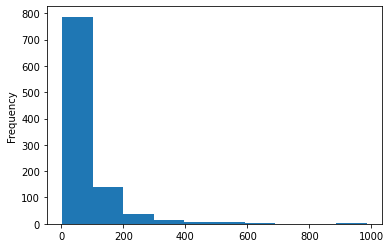

In [ ]:
raw_df.comment_text.sample(1000).map(tokenizer).map(len).plot(kind='hist')

In [ ]:
MAX_LENGTH = 150

In [ ]:
def pad_tokens(tokens):
  if len(tokens) >= MAX_LENGTH:
    return tokens[:MAX_LENGTH]
  else:
    return tokens + [pad_token] * (MAX_LENGTH - len(tokens))

In [ ]:
import torch

In [ ]:
class JigsawDataset(Dataset):
  def __init__(self, df, is_test=False):
    self.df = df
    self.is_test = is_test
  
  def __getitem__(self, index):
    comment_text = self.df.comment_text.values[index]
    comment_tokens = pad_tokens(tokenizer(comment_text))
    input = torch.tensor(vocab.lookup_indices(comment_tokens))
    if self.is_test:
      target = torch.tensor([0, 0, 0, 0, 0, 0]).float()
    else:
      target = torch.tensor(self.df[target_cols].values[index]).float()
    return input, target

  def __len__(self):
    return len(self.df)

In [ ]:
raw_ds = JigsawDataset(raw_df)

In [ ]:
raw_ds[0]

(tensor([ 667,   85,    3,  140,  142,  185,   39,  663,    0,    0, 1287,   96,
          329,   27,   57,    0,    9,   31,    0,    4,   61,    0,   21,   71,
            0,  158,    6,    0,   45,  130, 1167,    0,    0,    2,    8,   55,
           70,    9,   31,  253,    3,  369,   41,    3,   50,   38,  155,    6,
            9,   81,    0,   99,    2,    0,    2,    0,    2,    0,    2, 1122,
            1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,
            1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,
            1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,
            1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,
            1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,
            1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,
            1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,
            1,    1,    1,  

In [ ]:
from torch.utils.data import random_split

In [ ]:
VAL_FRAC = 0.25

In [ ]:
train_ds, val_ds = random_split(raw_ds, [1-VAL_FRAC, VAL_FRAC])

In [ ]:
len(raw_ds), len(train_ds), len(val_ds)

(159571, 119679, 39892)

In [ ]:
test_ds = JigsawDataset(test_df, is_test=True)

In [ ]:
test_ds[0]

(tensor([   0,  636,    0,  649,   12,   69,    0,   93,   10,    9,  169,  359,
           23,    0,   89,   30,   10,    8,    0,   10, 1488,    0,    2,    2,
            2,    6,   68,  636,    0,    0,    0,  690,    0,    8,  105,   10,
            5,    0,   39,  419,   10,  699,    0,   46,    2,    0,  649,   12,
           47,    0,   15,    0,  668,  439,    2,  443,    0,   13,  332,   21,
          167,    2,    8,    0,   12,  251,    0,   62,    0,   59,   34,   11,
            0,  171,    2,    2,    2,    0,  690,    0,  105,  226,  160,  490,
           95,    2,    4,    1,    1,    1,    1,    1,    1,    1,    1,    1,
            1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,
            1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,
            1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,
            1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,
            1,    1,    1,  

### Create PyTorch Dataloaders

In [ ]:
from torch.utils.data import DataLoader

In [ ]:
BATCH_SIZE = 256

In [ ]:
train_dl = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, num_workers=8, pin_memory=True)
val_dl = DataLoader(val_ds, batch_size=BATCH_SIZE*2, num_workers=8, pin_memory=True)
test_dl = DataLoader(test_ds, batch_size=BATCH_SIZE*2, num_workers=8, pin_memory=True)

/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [ ]:
for batch in train_dl:
  b_inp, b_tar = batch
  print('b_inp.shape', b_inp.shape)
  print('b_tar.shape', b_tar.shape)

  break

b_inp.shape torch.Size([256, 150])
b_tar.shape torch.Size([256, 6])


## Build a Recurrent Neural Network

Outline:
1. Understand how recurrent neural networks work
2. Create a recurrent neural network
3. Pass some through the network

In [ ]:
import torch.nn as nn
import torch.functional as F

In [ ]:
emb_layer = nn.Embedding(VOCAB_SIZE, 256, 1)

In [ ]:
rnn_layer = nn.RNN(256, 128, 1, batch_first=True)

In [ ]:
for batch in train_dl:
  b_input, b_target = batch
  print('b_input.shape', b_input.shape)
  print('b_target.shape', b_target.shape)

  emb_out = emb_layer(b_input)
  print('emb_out.shape', emb_out.shape)
  
  rnn_out, hn = rnn_layer(emb_out)
  print('rnn_out.shape', rnn_out.shape)
  print('hn.shape', hn.shape)
  break

b_input.shape torch.Size([256, 150])
b_target.shape torch.Size([256, 6])
emb_out.shape torch.Size([256, 150, 256])
rnn_out.shape torch.Size([256, 150, 128])
hn.shape torch.Size([1, 256, 128])


In [ ]:
!pip install pytorch_lightning --quiet

     |████████████████████████████████| 800 kB 27.8 MB/s 
     |████████████████████████████████| 512 kB 74.0 MB/s 
     |████████████████████████████████| 125 kB 77.5 MB/s 


In [ ]:
import pytorch_lightning as pl

In [ ]:
import  torch.nn.functional as F

In [ ]:
class JigsawModel(pl.LightningModule):
  def __init__(self):
    super().__init__()
    self.emb = nn.Embedding(VOCAB_SIZE, 256, 1)
    self.lstm = nn.LSTM(256, 128, 1, batch_first=True)
    self.linear = nn.Linear(128, 6)
    self.lr = 0.001

  def forward(self, x):
    out = self.emb(x)
    out, hn = self.lstm(out)
    out = F.relu(out[:,-1,:])
    out = self.linear(out)
    return out

  def training_step(self, batch, batch_idx):
    inputs, targets = batch
    outputs = self(inputs)
    probs = torch.sigmoid(outputs)
    loss = F.binary_cross_entropy(probs, targets)
    return loss

  def validation_step(self, batch, batch_idx):
    inputs, targets = batch
    outputs = self(inputs)
    probs = torch.sigmoid(outputs)
    loss = F.binary_cross_entropy(probs, targets)
    return loss.item()
  
  def validation_epoch_end(self, validation_step_outputs):
    loss = np.mean(validation_step_outputs)
    print('Epoch #{}; Loss: {:4f}'.format(self.current_epoch, loss))

  def predict_step(self, batch, batch_idx):
    inputs, targets = batch
    outputs = self(inputs)
    probs = torch.sigmoid(outputs)
    return probs

  def configure_optimizers(self):
    return torch.optim.Adam(self.parameters(), lr=self.lr)

In [ ]:
model = JigsawModel()

In [ ]:
for batch in train_dl:
  b_inputs, b_targets = batch
  print('b_inputs.shape', b_inputs.shape)
  print('b_targets.shape', b_targets.shape)

  outputs = model(b_inputs)
  print('output.shape', outputs.shape)
  
  probs = torch.sigmoid(outputs)
  loss = F.binary_cross_entropy(probs, b_targets)
  print('Loss', loss)
  break

/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


b_inputs.shape torch.Size([256, 150])
b_targets.shape torch.Size([256, 6])
output.shape torch.Size([256, 6])
Loss tensor(0.6752, grad_fn=<BinaryCrossEntropyBackward0>)


## Train and Evaluate the Model

In [ ]:
trainer = pl.Trainer(max_epochs=3, accelerator='gpu', auto_lr_find=True)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


In [ ]:
trainer.tune(model, train_dl)

/usr/local/lib/python3.8/dist-packages/pytorch_lightning/trainer/configuration_validator.py:108: PossibleUserWarning: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
  rank_zero_warn(
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=100` reached.
INFO:pytorch_lightning.tuner.lr_finder:Learning rate set to 0.005754399373371567
INFO:pytorch_lightning.utilities.rank_zero:Restoring states from the checkpoint path at /content/.lr_find_1d10dd4b-6a84-4f0e-99a7-c4a2c8b2760d.ckpt
INFO:pytorch_lightning.utilities.rank_zero:Restored all states from the checkpoint file at /content/.lr_find_1d10dd4b-6a84-4f0e-99a7-c4a2c8b2760d.ckpt


{'lr_find': <pytorch_lightning.tuner.lr_finder._LRFinder at 0x7f45d752ed60>}

In [ ]:
model.lr

0.005754399373371567

In [ ]:
trainer.fit(model, train_dl, val_dl)

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name   | Type      | Params
-------------------------------------
0 | emb    | Embedding | 384 K 
1 | lstm   | LSTM      | 197 K 
2 | linear | Linear    | 774   
-------------------------------------
582 K     Trainable params
0         Non-trainable params
582 K     Total params
2.330     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Epoch #0; Loss: 0.674725


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Epoch #0; Loss: 0.098553


Validation: 0it [00:00, ?it/s]

Epoch #1; Loss: 0.075274


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=3` reached.


Epoch #2; Loss: 0.065614


## Make Predictions & Submit

In [ ]:
test_preds = trainer.predict(model, test_dl)

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 468it [00:00, ?it/s]

In [ ]:
len(test_preds)

300

In [ ]:
test_preds = torch.cat(test_preds)

In [ ]:
test_preds.shape

torch.Size([153164, 6])

In [ ]:
test_preds

tensor([[9.8968e-01, 3.8417e-01, 9.5364e-01, 5.0421e-02, 9.0818e-01, 1.4568e-01],
        [8.5422e-03, 1.1436e-04, 2.2603e-03, 2.3452e-04, 2.8492e-03, 4.3667e-04],
        [8.2874e-03, 1.1112e-04, 2.2247e-03, 2.2474e-04, 2.7729e-03, 4.2479e-04],
        ...,
        [1.3705e-02, 1.6992e-04, 3.3905e-03, 3.8497e-04, 4.7144e-03, 7.2079e-04],
        [5.9149e-03, 8.6437e-05, 1.6435e-03, 1.6421e-04, 2.0055e-03, 3.0380e-04],
        [5.2391e-01, 1.1085e-02, 1.7818e-01, 1.4033e-02, 2.2015e-01, 2.2361e-02]])

In [ ]:
test_probs = torch.sigmoid(test_preds)

In [ ]:
sub_df

,id,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,00001cee341fdb12,0.5,0.5,0.5,0.5,0.5,0.5
1,0000247867823ef7,0.5,0.5,0.5,0.5,0.5,0.5
2,00013b17ad220c46,0.5,0.5,0.5,0.5,0.5,0.5
3,00017563c3f7919a,0.5,0.5,0.5,0.5,0.5,0.5
4,00017695ad8997eb,0.5,0.5,0.5,0.5,0.5,0.5
...,...,...,...,...,...,...,...
153159,fffcd0960ee309b5,0.5,0.5,0.5,0.5,0.5,0.5
153160,fffd7a9a6eb32c16,0.5,0.5,0.5,0.5,0.5,0.5
153161,fffda9e8d6fafa9e,0.5,0.5,0.5,0.5,0.5,0.5
153162,fffe8f1340a79fc2,0.5,0.5,0.5,0.5,0.5,0.5


In [ ]:
sub_df[target_cols] = test_preds.detach().cpu().numpy()

In [ ]:
sub_df

,id,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,00001cee341fdb12,0.989677,0.384172,0.953645,0.050421,0.908182,0.145676
1,0000247867823ef7,0.008542,0.000114,0.002260,0.000235,0.002849,0.000437
2,00013b17ad220c46,0.008287,0.000111,0.002225,0.000225,0.002773,0.000425
3,00017563c3f7919a,0.007495,0.000103,0.002029,0.000203,0.002500,0.000383
4,00017695ad8997eb,0.024601,0.000278,0.005661,0.000748,0.008434,0.001287
...,...,...,...,...,...,...,...
153159,fffcd0960ee309b5,0.101893,0.001127,0.021669,0.003133,0.034406,0.004559
153160,fffd7a9a6eb32c16,0.045880,0.000484,0.010062,0.001412,0.015755,0.002297
153161,fffda9e8d6fafa9e,0.013705,0.000170,0.003391,0.000385,0.004714,0.000721
153162,fffe8f1340a79fc2,0.005915,0.000086,0.001644,0.000164,0.002005,0.000304


In [ ]:
sub_df.to_csv('submission.csv', index=None)

In [ ]:
!head submission.csv

id,toxic,severe_toxic,obscene,threat,insult,identity_hate
00001cee341fdb12,0.98967665,0.38417232,0.95364463,0.0504215,0.9081821,0.14567621
0000247867823ef7,0.008542186,0.000114363575,0.0022603224,0.00023451519,0.0028491872,0.00043667498
00013b17ad220c46,0.008287423,0.00011111533,0.0022247022,0.00022473883,0.0027728844,0.00042479162
00017563c3f7919a,0.0074946955,0.000102727434,0.002029191,0.00020302819,0.0025001657,0.00038278513
00017695ad8997eb,0.024601327,0.00027830995,0.0056610196,0.00074772537,0.008434202,0.0012872571
0001ea8717f6de06,0.007884062,0.00010668096,0.0021142883,0.00021625786,0.0026286957,0.0004023203
00024115d4cbde0f,0.013619997,0.00017380231,0.0032276672,0.00040984282,0.004519391,0.0006953524
000247e83dcc1211,0.06910975,0.0007338361,0.014784116,0.0021273152,0.023523942,0.0032828457
00025358d4737918,0.0027668707,2.9825404e-05,0.0007216071,7.170576e-05,0.0007794244,0.00011861434
